## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '60m'

# time span of data e.g. 2y for 60m, 10y for 1d
period = '2y'

perc_inc = 0.005 # 0.5 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'ITOT' # ITOT iShares TOTAL Market ETF stock

perc_train = 0.25 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = period
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-06-20 08:00:00-04:00,63.890000,63.890000,63.890000,63.890000,63.890000,0
2018-06-20 09:30:00-04:00,64.080002,64.105003,63.930000,63.930000,63.930000,140337
2018-06-20 10:30:00-04:00,63.970001,64.083504,63.919998,64.059998,64.059998,100727
2018-06-20 11:30:00-04:00,64.070000,64.150002,64.040001,64.110001,64.110001,46765
2018-06-20 12:30:00-04:00,64.119904,64.204498,64.110001,64.120003,64.120003,51480


### EDA of Secruity

In [5]:
stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume,percent change
Datetime,,,,,,,
2018-06-20 08:00:00-04:00,63.890000,63.890000,63.890000,63.890000,63.890000,0,0.000000
2018-06-20 09:30:00-04:00,64.080002,64.105003,63.930000,63.930000,63.930000,140337,0.002341
2018-06-20 10:30:00-04:00,63.970001,64.083504,63.919998,64.059998,64.059998,100727,-0.001407
2018-06-20 11:30:00-04:00,64.070000,64.150002,64.040001,64.110001,64.110001,46765,-0.000624
2018-06-20 12:30:00-04:00,64.119904,64.204498,64.110001,64.120003,64.120003,51480,-0.000002


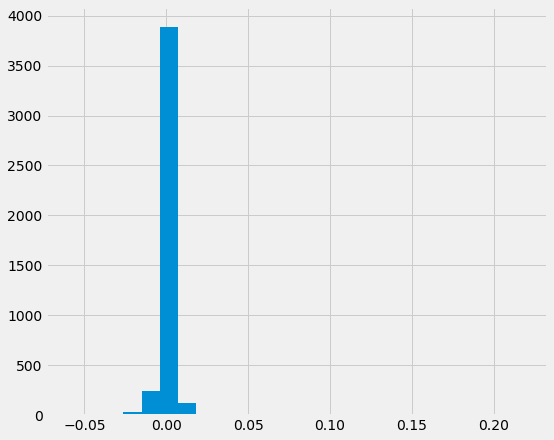

In [6]:
stock_df['percent change'].hist(bins=25);

In [7]:
stock_df['percent change'].quantile([0.84])

0.84    0.00192
Name: percent change, dtype: float64

### Assign Descisions for Up %+ or Not

In [8]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [9]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2020-06-18 11:30:00-04:00,69.779999,69.849998,69.480103,69.709999,69.709999,96821,0.001003,0
2020-06-18 12:30:00-04:00,69.709999,69.769997,69.580002,69.739998,69.739998,81552,-0.000430,0
2020-06-18 13:30:00-04:00,69.750000,69.839996,69.565002,69.686302,69.686302,125833,0.000913,0
2020-06-18 14:30:00-04:00,69.699898,69.790001,69.430000,69.589996,69.589996,190707,0.001577,0
2020-06-18 15:30:00-04:00,69.589996,69.815002,69.540001,69.809998,69.809998,129329,-0.003161,0
2020-06-18 16:00:00-04:00,69.810000,69.810000,69.810000,69.810000,69.810000,0,0.000000,0
2020-06-19 09:30:00-04:00,70.669998,70.680000,70.290001,70.385002,70.385002,158337,0.004033,0
2020-06-19 10:30:00-04:00,70.389999,70.389999,70.139999,70.230003,70.230003,107960,0.002273,0
2020-06-19 11:30:00-04:00,70.239998,70.239998,69.239998,69.510002,69.510002,178128,0.010393,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [10]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [11]:
len(decisions)

4320

In [12]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [13]:
len(decisions)

4319

In [14]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(4319, 8)

In [15]:
stock_df_one_off.iloc[-1]

Open                69.42000
High                69.42000
Low                 69.00000
Close               69.00000
Adj Close           69.00000
Volume            8823.00000
percent change       0.00605
decision             0.00000
Name: 2020-06-19 16:00:00-04:00, dtype: float64

In [16]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2018-06-20 08:00:00-04:00,63.890000,63.890000,63.890000,63.890000,63.890000,0,0.000000,0
2018-06-20 09:30:00-04:00,64.080002,64.105003,63.930000,63.930000,63.930000,140337,0.002341,0
2018-06-20 10:30:00-04:00,63.970001,64.083504,63.919998,64.059998,64.059998,100727,-0.001407,0
2018-06-20 11:30:00-04:00,64.070000,64.150002,64.040001,64.110001,64.110001,46765,-0.000624,0
2018-06-20 12:30:00-04:00,64.119904,64.204498,64.110001,64.120003,64.120003,51480,-0.000002,0


In [17]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    4125
1     194
Name: decision, dtype: int64

### Balance the 0's and 1's

In [18]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

194

In [19]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [20]:
stock_df_bal.shape

(388, 8)

In [21]:
stock_df_bal.decision.value_counts()

1    194
0    194
Name: decision, dtype: int64

### Check for NaN's

In [22]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

In [23]:
stock_df_bal.dropna(axis=0, inplace=True)

In [24]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

### Train Test Split

In [25]:
X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  77 out of  77 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  77 out of  77 | elapsed:    0.0s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [28]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.8527777777777777

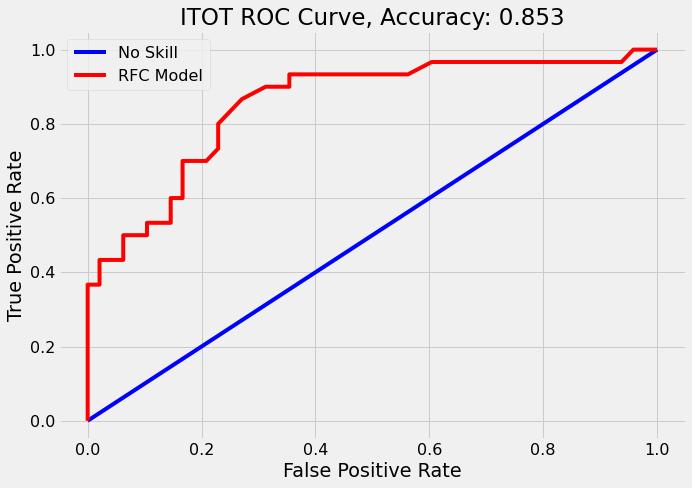

In [29]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  77 out of  77 | elapsed:    0.0s finished


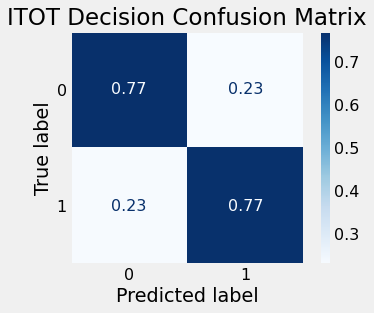

In [30]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                           , X_test
                           , y_test
                           , cmap=plt.cm.Blues
                           , normalize='true'
                     )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

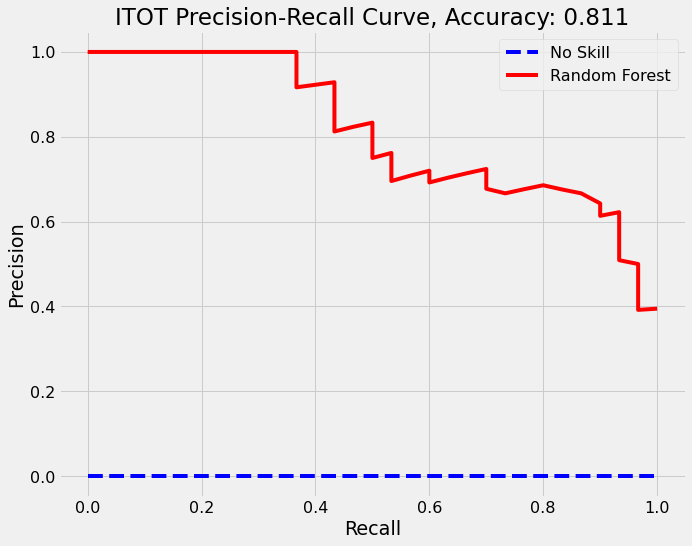

In [31]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [32]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
5,Volume,0.217959
3,Close,0.169029
1,High,0.164126
2,Low,0.163832
4,Adj Close,0.152795
0,Open,0.132259


In [33]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
0,61.000000,61.000000,60.010100,60.010100,60.010100,0,0.016228,0
1,65.268997,65.320000,65.150002,65.169998,65.169998,74685,0.001517,0
2,70.285004,70.364998,70.139999,70.220001,70.220001,180296,0.000925,0
3,60.970001,61.133202,60.950001,61.110001,61.110001,138408,-0.002296,0
4,63.240101,63.450001,63.169998,63.259998,63.259998,534898,-0.000315,0


### Make A Prediction

In [34]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open         68.59
High         68.59
Low          68.59
Close        68.59
Adj Close    68.59
Volume        0.00
Name: 2020-06-19 17:00:00-04:00, dtype: float64

In [35]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Sell or hold ITOT on the 60m interval.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  77 out of  77 | elapsed:    0.0s finished
